# **Rodrigo_Mesquita_PB_TP4**
## **Projeto de Bloco: Inteligência Artificial e Machine Learning [24E1_5]**

**Objetivos:**

* Investigar a eficácia do uso de clusters gerados pelo algoritmo K-Médias como features adicionais em tarefas de classificação.
* Comparar o desempenho de modelos SVM treinados com e sem o uso dessas features derivadas de clusterização em conjuntos de dados variados.
* Avaliar a influência do número de clusters e da seleção de parâmetros no desempenho do modelo SVM final.
* Desenvolver diretrizes para a aplicação efetiva de técnicas de clusterização em engenharia de features para aprendizado supervisionado.

<div style="background-color: #ffffb3; padding: 10px;">
Nota: Primeiro criei todas as funções para depois aplicar sequencialmente em cada dataset solicitado.

### 1.Clusterização K-Médias: Utilizaremos o algoritmo K-Médias para agrupar os dados do conjunto de treinamento. O número ótimo de clusters será determinado com base em métricas como o método do cotovelo e o índice de silhueta.

In [1]:
%pip install yellowbrick

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.datasets import load_iris, load_digits, load_breast_cancer, load_wine
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import silhouette_score, mean_squared_error, confusion_matrix, multilabel_confusion_matrix, precision_score, recall_score, f1_score,accuracy_score, classification_report, ConfusionMatrixDisplay, roc_auc_score
from scipy.spatial.distance import cdist
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.ensemble import RandomForestClassifier

In [3]:
#Após instalar o yellowbrick começou a dar erro de fonte, pois ele tenta usar uma fonte não disponível no ambiente, então tive de adicionar essa linha
plt.rcParams['font.sans-serif'] = 'DejaVu Sans'

In [4]:
def treinar_kmeans(X,Y):
    np.random.seed(42)

    X_std = StandardScaler().fit_transform(X)

    #Treinar o Kmeans e iterar com diferentes valores de K para avaliar a quantidade idade, utilizando os métodos elbow e silhouette
    elbow, silhouette = {},{}
    for k in range(2, 31, 1):
        model = KMeans(n_clusters= k, max_iter=1000,n_init=1, random_state=42).fit(X_std)
        preds = model.predict(X_std)
        elbow[k] = mean_squared_error(Y,preds)
        silhouette[k] = silhouette_score(X_std,preds)

    #Plortar os gráficos de Elbow e Silhouete
    maximo = max(elbow.values())
    for key in elbow:
        elbow[key] = float(elbow[key]) / maximo

    #Gráfico Elbow
    fig, ax1 = plt.subplots(figsize=(8, 4))
    ax1.plot(list(elbow.keys()), list(elbow.values()), label="Método Elbow", color='b')
    ax1.set_xlabel('Clusters', fontsize=12)
    ax1.set_ylabel('MSE', fontsize=12, color='b')
    ax1.set_ylim(0, 1)
    ax1.tick_params('y', colors='b')
    ax1.legend(loc='upper right')

    #Ajustar o Xticks para que seja de 1 em 1
    ax1.set_xticks(list(elbow.keys()))
    ax1.set_xticklabels(list(elbow.keys()))
    #Adicionar grid vertical
    ax1.grid(visible=True, axis='x', linestyle='-', color='gray', alpha=0.5)
    
    # Gráfico Silhouete
    ax2 = ax1.twinx()
    ax2.plot(list(silhouette.keys()), list(silhouette.values()), label="Método Silhouette", color='r')
    ax2.set_ylabel('Silhouette Score', fontsize=12, color='r')
    ax2.set_ylim(0, 1)
    ax2.tick_params('y', colors='r')
    ax2.legend(loc='upper center')

    plt.title('Elbow Plot e Silhouette Plot')
    plt.show()

### 2.Criação de Features: Para cada instância nos conjuntos de treinamento e teste, será gerada uma nova feature indicando a distância da instância ao centro do cluster mais próximo. Este processo visa incorporar a estrutura de agrupamento dos dados como uma informação adicional para o modelo de aprendizado supervisionado.

In [5]:
#Função para criar os novos datasets com os valores de K determinados.

def criar_feature(X,K):

    model = KMeans(n_clusters= K, max_iter=1000,n_init=1, random_state=42).fit(X)

    #Uso "cluster_centers" para retornar as coordenadas do centro de cada cluster.
    cluster_centers = model.cluster_centers_

    #cdist retorna a distancia entre cada amostra e o centro de cada cluster e o np.min pega a menor distância (distância para o cluster mais próximo).
    distances = np.min(cdist(X, cluster_centers), axis=1)

    X_New = np.column_stack((X, distances))

    #Visualizar o Silhouette por cluster com o K escolhido
    SilhouetteVisualizer(model).fit(X).show()

    return X_New


### 3.Modelo de ML: Serão treinados utilizando tanto o conjunto de features original quanto o conjunto de features expandido com as distâncias dos clusters. Use:

>> ### 3a.Modelos SVM com diferentes configurações de kernel (linear, polinomial, RBF) e parâmetros de regularização para otimizar o desempenho.

>> ### 3b.Modelos Random Forest com diferentes parâmetros para otimizar o desempenho.

In [6]:
#Função para treinar os modelos SVM ou Random Forest e calcular as métricas

def treinar_modelo(X1,X2,Y, test_size, modelo, param_grid, cv):

    #A função recebe 2 conjuntos de testes distintos, o que original e o que possui a feature de distância calculada pelo K-Means
    x_train1, x_test1, y_train1, y_test1 = train_test_split(X1, Y, test_size = test_size, random_state=20)
    x_train2, x_test2, y_train2, y_test2 = train_test_split(X2, Y, test_size = test_size, random_state=20)

    #Treino primeiro o modelo com o df original
    model1 = GridSearchCV(modelo, param_grid, cv = cv)
    model1.fit(x_train1, y_train1)
    y_pred1 = model1.predict(x_test1)

    #Depois treino o modelo com o df que possui feature calculada
    model2 = GridSearchCV(modelo, param_grid, cv=5)
    model2.fit(x_train2, y_train2)
    y_pred2 = model2.predict(x_test2)

    return model1, y_test1, y_pred1, model2, y_test2, y_pred2

### 4.Avaliação de Modelos: O desempenho dos modelos será avaliado com base em métricas de classificação padrão, como precisão, recall, F1-score e AUC-ROC, utilizando os conjuntos de teste.

In [7]:
#Plotar as métricas
def plotar_metricas(model1, y_test1, y_pred1, model2, y_test2,y_pred2):

    #Métricas DF original
    best_param1 = model1.best_params_
    best_FS1 = model1.best_score_
    fs1 = f1_score(y_test1, y_pred1, average='macro')
    acc1 = accuracy_score(y_test1, y_pred1)
    prec1 = precision_score(y_test1, y_pred1, average='macro')
    rec1 = recall_score(y_test1, y_pred1, average='macro')

    #Calculando a Especificidade
    mc = metrics.multilabel_confusion_matrix(y_test1, y_pred1)
    TP,FN,FP,TN = mc[:, 1, 1], mc[:, 1, 0], mc[:, 0, 1], mc[:, 0, 0]
    Espec1 = np.mean(TN / (TN + FP), axis=0)

    #Calculando o AUC em um problema multiclasse
    classes = np.unique(y_test1)
    y_test_bin = label_binarize(y_test1, classes=np.unique(classes))
    y_pred_bin = label_binarize(y_pred1, classes=np.unique(classes))
    auc1 = roc_auc_score(y_test_bin, y_pred_bin, multi_class='ovo', average='macro')

    #Métricas DF com feature calculada
    best_param2 = model2.best_params_
    best_FS2 = model2.best_score_
    fs2 = f1_score(y_test2, y_pred2, average='macro')
    acc2 = accuracy_score(y_test2, y_pred2)
    prec2 = precision_score(y_test2, y_pred2, average='macro')
    rec2 = recall_score(y_test2, y_pred2, average='macro')

    #Calculando a Especificidade
    mc = metrics.multilabel_confusion_matrix(y_test1, y_pred1)
    TP,FN,FP,TN = mc[:, 1, 1], mc[:, 1, 0], mc[:, 0, 1], mc[:, 0, 0]
    Espec2 = np.mean(TN / (TN + FP), axis=0)

    #Calculando o AUC em um problema multiclasse
    classes = np.unique(y_test2)
    y_test_bin = label_binarize(y_test2, classes=np.unique(classes))
    y_pred_bin = label_binarize(y_pred2, classes=np.unique(classes))
    auc2 = roc_auc_score(y_test_bin, y_pred_bin, multi_class='ovo', average='macro')

    #Imprimindo resultados
    print(f"Melhores Parâmetros: Df Orig: ", best_param1 ," Novo:",best_param2)
    print(f"Melhores Score: Df Orig: {best_FS1:.0%} | Novo:{best_FS2:.0%}")
    print(f"F1-score:       Df Orig:{fs1:.0%} | Novo:{fs2:.0%}")
    print(f"Acurácia:       Df Orig:{acc1:.0%} | Novo:{acc2:.0%}")
    print(f"Precisão:       Df Orig:{prec1:.0%} | Novo:{prec2:.0%}")
    print(f"Recall:         Df Orig:{rec1:.0%} | Novo:{rec2:.0%}")
    print(f"Especificidade: Df Orig:{Espec1:.0%} | Novo:{Espec2:.0%}")
    print(f"AUC:            Df Orig:{auc1:.0%} | Novo:{auc2:.0%}")

In [8]:
#Criada função para imprimir as matrizes de confusão:
def plotar_matriz(model1, y_test1, y_pred1, model2, y_test2,y_pred2, W, H):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(W, H))
    plt.rcdefaults()
    
    cm1 = metrics.confusion_matrix(y_test1, y_pred1)
    disp1 = ConfusionMatrixDisplay(confusion_matrix=cm1)
    disp1.plot(ax=ax1, cmap='Blues', colorbar=False)
    ax1.set_title('DF Original')

    cm2 = metrics.confusion_matrix(y_test2, y_pred2)
    disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2)
    disp2.plot(ax=ax2, cmap='Blues', colorbar=False)
    ax2.set_title('Feature Adicionada')


    plt.tight_layout()
    plt.show()

# **DATASET IRIS**

### 1. Clusterização K-Médias: Treinar K-médias e descobrir o número ótimo de clusters com base em métricas como o método do cotovelo e o índice de silhueta.

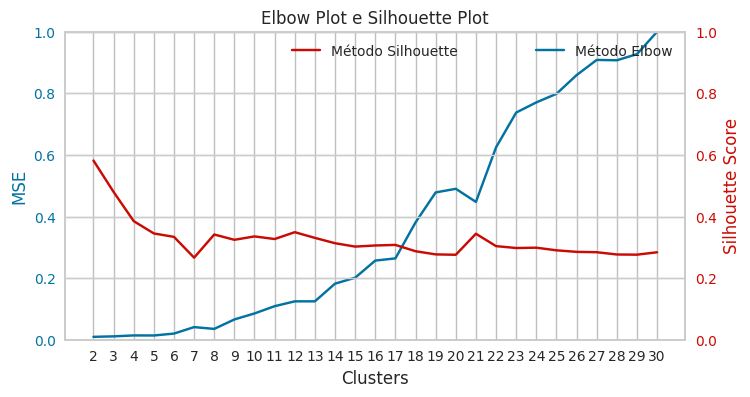

In [9]:
df = load_iris()
X = df.data
Y = df.target

treinar_kmeans(X,Y)

### 2. Criação de Features: Gerar nova feature indicando a distância da instância ao centro do cluster mais próximo.

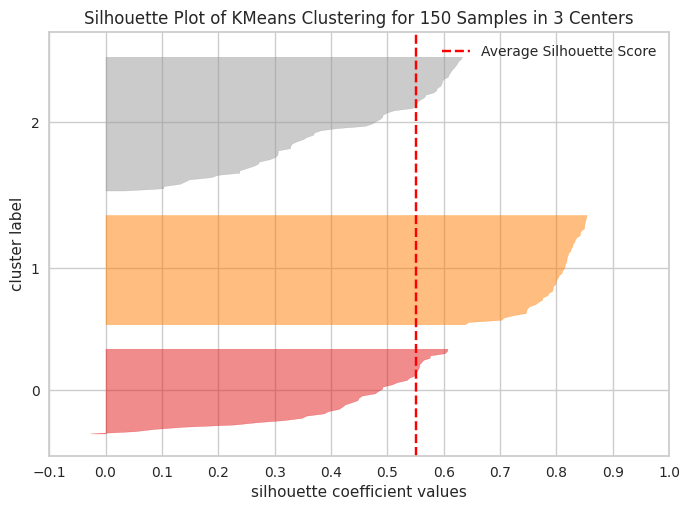

In [10]:
X_New = criar_feature(X, K=3)

### 3.a e 4 SVM - Modelos SVM com diferentes kernels e parâmetros de regularização + Avaliação de Modelos

In [20]:
param_grid = {'kernel': ['linear', 'rbf', 'sigmoid'], 'C': [0.001, 0.01, 0.1, 1, 10, 100], 'decision_function_shape':['ovo']}
model1, y_test1, y_pred1, model2, y_test2, y_pred2 = treinar_modelo(X, X_New, Y, 0.30, SVC(), param_grid, 5)

In [21]:
plotar_metricas(model1, y_test1, y_pred1, model2, y_test2, y_pred2)

Melhores Parâmetros: Df Orig:  {'C': 1, 'decision_function_shape': 'ovo', 'kernel': 'linear'}  Novo: {'C': 1, 'decision_function_shape': 'ovo', 'kernel': 'linear'}
Melhores Score: Df Orig: 98% | Novo:97%
F1-score:       Df Orig:93% | Novo:96%
Acurácia:       Df Orig:93% | Novo:96%
Precisão:       Df Orig:95% | Novo:97%
Recall:         Df Orig:93% | Novo:95%
Especificidade: Df Orig:96% | Novo:96%
AUC:            Df Orig:95% | Novo:96%


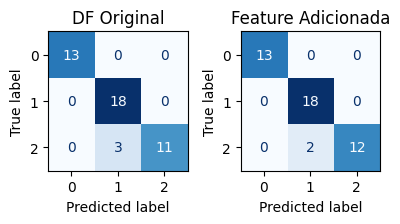

In [22]:
plotar_matriz(model1, y_test1, y_pred1, model2, y_test2,y_pred2,W=4,H=4)

<div style="background-color: #ffffb3; padding: 10px;">
Nota: Rodei novamente o modelo, escolhendo o kernel ideal e valores de C mais próximos ao melhor da iteração anterior. Como deu 100% de Acc, Recall e Precisão, optei por aumentar o tamanho do conjunto de testes e de validações cruzadas para garantir que não era overfitting.

In [27]:
param_grid={'C':[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.9, 1, 2, 3, 4, 5,6, 7, 8, 9, 10], 'decision_function_shape':['ovo'], 'kernel':['linear']}
model1, y_test1, y_pred1, model2, y_test2, y_pred2 = treinar_modelo(X, X_New, Y, 0.40, SVC(), param_grid, 15)

In [28]:
x_train, x_test, y_train, y_test = train_test_split(X_New, Y, test_size=0.30, random_state=20)
param_grid={'C':[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.9, 1, 2, 3, 4, 5,6, 7, 8, 9, 10]}
model = GridSearchCV(SVC(decision_function_shape='ovo', kernel='linear'),param_grid, cv=15)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

#Métricas DF com feature calculada
print(f"Melhores Parâmetros:", model.best_params_)
print(f"Acurácia: {accuracy_score(y_test, y_pred):.0%}")
print(f"Precisão: {precision_score(y_test, y_pred, average='macro'):.0%}")
print(f"Recall: {recall_score(y_test, y_pred, average='macro'):.0%}")

Melhores Parâmetros: {'C': 0.4}
Acurácia: 100%
Precisão: 100%
Recall: 100%


### 3.b e 4 Random Forest - Modelos Random Forest com diferentes parâmetros + Avaliação de Modelos

<div style="background-color: #ffffb3; padding: 10px;">
Nota: Também testei com n_estimators 200, porém os melhores parâmetros estavam retornando com 100, então retirei pois estava aumentando muito o tempo de processamento e dificultando os testes com outros parâmetros.

In [39]:
param_grid = {
    'n_estimators': [100],
    'max_depth': [3, 5, 10, 15],
    'max_features': ['sqrt'],
    'criterion': ['gini', 'entropy'],
    'min_samples_split': [5, 10, 20],
    'min_samples_leaf': [2, 5, 10],
    'bootstrap': [True]
}

model1, y_test1, y_pred1, model2, y_test2, y_pred2 = treinar_modelo(X, X_New, Y, 0.30, RandomForestClassifier(), param_grid, 5)

In [40]:
plotar_metricas(model1, y_test1, y_pred1, model2, y_test2, y_pred2)

Melhores Parâmetros: Df Orig:  {'bootstrap': True, 'criterion': 'gini', 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}  Novo: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Melhores Score: Df Orig: 98% | Novo:98%
F1-score:       Df Orig:89% | Novo:89%
Acurácia:       Df Orig:89% | Novo:89%
Precisão:       Df Orig:93% | Novo:93%
Recall:         Df Orig:88% | Novo:88%
Especificidade: Df Orig:94% | Novo:94%
AUC:            Df Orig:91% | Novo:91%


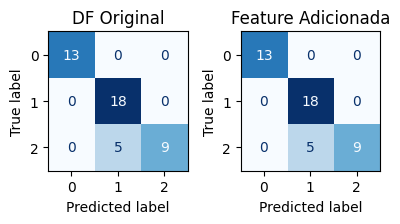

In [41]:
plotar_matriz(model1, y_test1, y_pred1, model2, y_test2,y_pred2,W=4,H=4)

# **DATASET DIGITS**

### 1. Clusterização K-Médias: Treinar K-médias e descobrir o número ótimo de clusters com base em métricas como o método do cotovelo e o índice de silhueta.

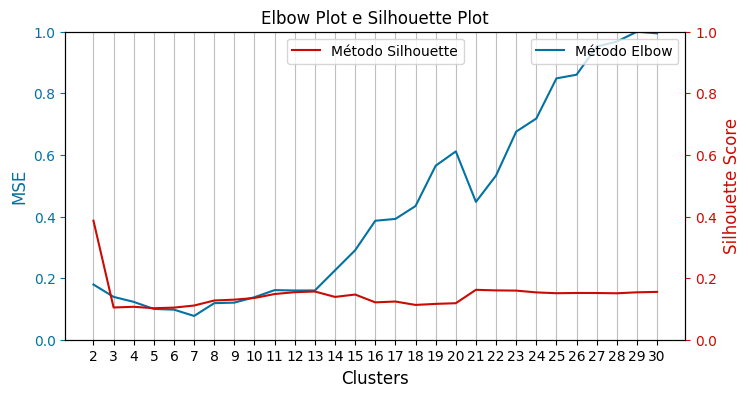

In [42]:
df = load_digits()
X = df.data
Y = df.target

treinar_kmeans(X,Y)

### 2. Criação de Features: Gerar nova feature indicando a distância da instância ao centro do cluster mais próximo.

<div style="background-color: #ffffb3; padding: 10px;">
Nota: Testei com K=8 e K=13, mas foi indiferente ao resultado visto nas métricas.

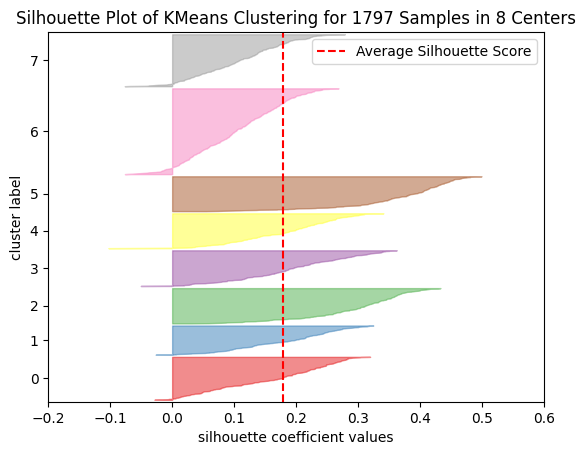

In [70]:
X_New = criar_feature(X, K=8)

### 3.a e 4 SVM - Modelos SVM com diferentes kernels e parâmetros de regularização + Avaliação de Modelos

In [87]:
param_grid = {'kernel': ['linear', 'rbf', 'sigmoid'], 'C': [ 1, 2, 3, 4, 5, 10, 15], 'decision_function_shape':['ovo']}
model1, y_test1, y_pred1, model2, y_test2, y_pred2 = treinar_modelo(X, X_New, Y, 0.40, SVC(), param_grid, 15)

<div style="background-color: #ffffb3; padding: 10px;">
Nota: Testei com diferentes ranges de 'C' e fui testando com valores mais próximos aos que eram apresentados como melhores pelo GridSearch, até alcançar os melhores scores. Após encontrar o melhor score aumentei o tamanho do conjunto de testes e o número de Cross Validation, para garantir que não era overfitting.

In [88]:
plotar_metricas(model1, y_test1, y_pred1, model2, y_test2, y_pred2)

Melhores Parâmetros: Df Orig:  {'C': 3, 'decision_function_shape': 'ovo', 'kernel': 'rbf'}  Novo: {'C': 5, 'decision_function_shape': 'ovo', 'kernel': 'rbf'}
Melhores Score: Df Orig: 99% | Novo:99%
F1-score:       Df Orig:99% | Novo:99%
Acurácia:       Df Orig:99% | Novo:99%
Precisão:       Df Orig:99% | Novo:99%
Recall:         Df Orig:99% | Novo:99%
Especificidade: Df Orig:100% | Novo:100%
AUC:            Df Orig:99% | Novo:99%


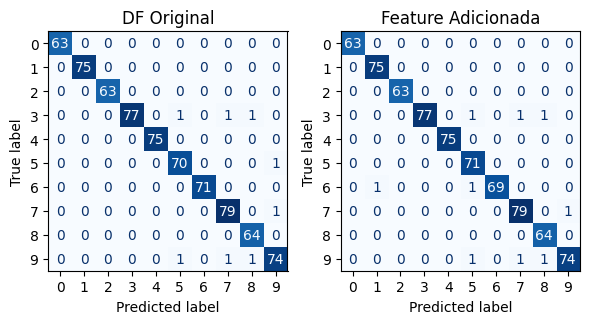

In [89]:
plotar_matriz(model1, y_test1, y_pred1, model2, y_test2,y_pred2,W=6,H=6)

### 3.b e 4 Random Forest - Modelos Random Forest com diferentes parâmetros + Avaliação de Modelos

In [ ]:
param_grid = {
    'n_estimators': [100],
    'max_depth': [3, 5, 10, 15],
    'max_features': ['sqrt'],
    'criterion': ['gini', 'entropy'],
    'min_samples_split': [5, 10, 20],
    'min_samples_leaf': [2, 5, 10],
    'bootstrap': [True]
}

model1, y_test1, y_pred1, model2, y_test2, y_pred2 = treinar_modelo(X, X_New, Y, 0.30, RandomForestClassifier(), param_grid, 5)

In [ ]:
plotar_metricas(model1, y_test1, y_pred1, model2, y_test2, y_pred2)

In [ ]:
plotar_matriz(model1, y_test1, y_pred1, model2, y_test2,y_pred2,W=4,H=4)

# **DATASET WINE**

### 1. Clusterização K-Médias: Treinar K-médias e descobrir o número ótimo de clusters com base em métricas como o método do cotovelo e o índice de silhueta.

### 2. Criação de Features: Gerar nova feature indicando a distância da instância ao centro do cluster mais próximo.

In [ ]:
### 3.a e 4 SVM - Modelos SVM com diferentes kernels e parâmetros de regularização + Avaliação de Modelos

In [ ]:
### 3.b e 4 Random Forest - Modelos Random Forest com diferentes parâmetros + Avaliação de Modelos

# **DATAST BREAST CANCER**

In [ ]:
### 1. Clusterização K-Médias: Treinar K-médias e descobrir o número ótimo de clusters com base em métricas como o método do cotovelo e o índice de silhueta.

In [ ]:
### 2. Criação de Features: Gerar nova feature indicando a distância da instância ao centro do cluster mais próximo.

In [ ]:
### 3.a e 4 SVM - Modelos SVM com diferentes kernels e parâmetros de regularização + Avaliação de Modelos

In [ ]:
### 3.b e 4 Random Forest - Modelos Random Forest com diferentes parâmetros + Avaliação de Modelos

## 5.Análise Comparativa: Será realizada uma análise comparativa para avaliar o impacto da adição das features de clusterização no desempenho dos modelos de ML. Além disso, será discutida a influência do número de clusters e das configurações do ML nas métricas de desempenho. Use gráficos para ilustrar seus argumentos.